In [1]:
import numpy as np

c = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7,3)
h = np.matmul(c, W)
print(h)

[[-0.79616509 -0.8580803   1.62868143]]


In [2]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7,3)
layer = MatMul(W)
h = layer.forward(c)
print(h)


[[ 1.52959564 -0.12338316 -0.56880772]]


In [4]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

# 가중치 초기화
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

# 계층 생성
## 두 개의 단어를 고려하므로 input layer가 2개(= 맥락 데이터 개수)
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1) # 두 입력층의 평균
s = out_layer.forward(h)

print(s)

[[ 2.00352891  0.95336266  0.42016543 -0.10064503 -1.62890902  0.50304293
  -0.71228123]]


In [5]:
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print()
print(id_to_word)

[0 1 2 3 4 1 5 6]

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [6]:
def create_contexts_target(corpus, window_size=1):
    ''' 맥락과 타깃 생성
    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함됨
    :return: (맥락, 타겟)의 np.array
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        # window_size만큼 타겟 단어 좌우 context 가져오기
        for t in range(-window_size, window_size+1):
            if t != 0:
                cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [7]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)
print()
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]

[1 2 3 4 1 5]


In [8]:
# one-hot 표현으로 변환

def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환
    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0] #단어 수 
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1 # 해당되는 ID 위치에 1을 대입(원-핫 벡터 생성)
        
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
    
    return one_hot


In [9]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [10]:
print(target)
print()
print(contexts)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


## CBOW 모델 구현

In [14]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f') # 0.01(가중치를 작은 값으로 초기화 -> 안정적 학습 가능(너무 크면 출력값이 과도하게 커지고, 작으면 학습 느림))
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out.T

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:,0])
        h1 = self.in_layer1.forward(contexts[:,1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        
        return None


In [15]:
# 학습 코드 구현

import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)

#cbow 학습 데이터셋 생성
contexts, target = create_contexts_target(corpus, window_size)

#Input에 맞는 one-hot 표현 변환
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

#모델 초기화
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

#모델 학습
trainer.fit(contexts, target, max_epoch, batch_size)

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

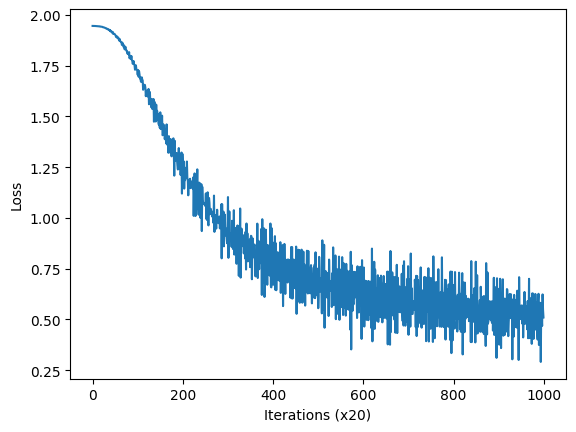

In [16]:
trainer.plot()

In [17]:
# word embedding 확인

word_vecs1 = model.word_vecs1

for word_id, word in id_to_word.items():
    print(word, word_vecs1[word_id])

you [-1.5121024   1.0044732   0.98046035  0.94762903 -0.98687655]
say [-0.20537622 -1.178369   -1.1855536  -1.1729437   0.30830216]
goodbye [-0.3222862   0.8371432   0.82577187  0.86390936 -1.110645  ]
and [-1.621555   -0.927119   -0.90698314 -0.90348214  1.4562172 ]
i [-0.29803166  0.83972746  0.8361682   0.88015336 -1.1076872 ]
hello [-1.5277891   0.998342    0.9945463   0.94593817 -0.99404174]
. [ 1.3694366 -1.097496  -1.1107475 -1.1127291 -1.546602 ]
